# autoTS: Spectral Analysis template

This notebook describes a workflow for spectral analysis. It can be used as a template for similar analysis. Each cell represents a worflow component (input not written to disk). 

**Table of contents**
* Generating Data
* Pre-processing
    * Standardization
    * Detrend
    * Detect/Remove outliers
    * Hypothesize over missing values (if needed: function or metadata)
* Analysis
    * Spectral analysis
    * Significance testing 
* Visualization
    * Periodogram
    
Functions are available through the [Pyleoclim package](https://github.com/LinkedEarth/Pyleoclim_util/tree/Development) on the development branch.

In [1]:
import pyleoclim as pyleo

Functions to handle writing in and out of "components"

In [2]:
import json
import numpy as np

def transform(obj_dict):
    for k in obj_dict.keys():
        if isinstance(obj_dict[k],(np.ndarray)):
            obj_dict[k] = obj_dict[k].tolist()
        elif isinstance(obj_dict[k],(pyleo.Series,pyleo.PSD)):
            obj_dict[k]=PyleoObj_to_json(obj_dict[k],dict_return=True)
        elif isinstance(obj_dict[k],pyleo.MultiplePSD):
            obj_dict[k]=PyleoObj_to_json(obj_dict[k],dict_return=True)
            c=[]
            idx = np.arange(0,len(obj_dict[k]['psd_list']),1).tolist()
            for item in idx:
                PSD_dict=PyleoObj_to_json(obj_dict[k]['psd_list'][item],dict_return=True)
                c.append(PSD_dict)
            obj_dict[k]['psd_list']=c            
        elif isinstance(obj_dict[k],(dict)):
            obj_dict[k]=transform(obj_dict[k])
    return obj_dict


def list_to_array(obj_dict):
    for k in obj_dict:
        if type(obj_dict[k])is dict:
            obj_dict[k]=list_to_array(obj_dict[k])
        elif type(obj_dict[k]) is list:
            obj_dict[k]=np.array(obj_dict[k])
        else:
            obj_dict[k]=obj_dict[k]
    return obj_dict

def PyleoObj_to_json(PyleoObj,filename='trial',dict_return=False):
    obj_dict = PyleoObj.__dict__
    obj_dict = transform(obj_dict)
    if dict_return == False:
        with open('./IntermediateOutputs/'+filename+'.json','w') as f:
            json.dump(obj_dict, f)
            f.close()
    elif dict_return == True:
        return  obj_dict

def json_to_Series(filename):
    with  open('./IntermediateOutputs/'+filename+'.json','r') as f:
        t = json.load(f)
    ts = pyleo.Series(time=np.array(t['time']),
                     value=np.array(t['value']),
                     time_name=t['time_name'],
                     time_unit=t['time_unit'],
                     value_name=t['value_name'],
                     value_unit=t['value_unit'],
                     label=t['label']) 
    return ts

def PSD_to_MultiplePSD(series_list):
    idx = np.arange(0,len(series_list),1).tolist()
    d=[]
    for item in idx:
        t=series_list[item]
        PSD_obj=pyleo.PSD(frequency=np.array(t['frequency']),
                        amplitude=np.array(t['amplitude']),
                        label=t['label'],
                        timeseries = t['timeseries'],
                        spec_method = t['spec_method'],
                        spec_args =  t['spec_args'],
                        signif_qs = t['signif_qs'],
                    signif_method = t['signif_method'])
        d.append(PSD_obj)
    MPSD=pyleo.MultiplePSD(psd_list=d)
    return MPSD
        

def json_to_PSD(filename):
    with  open('./IntermediateOutputs/'+filename+'.json','r') as f:
        t = json.load(f)
    t = list_to_array(t)
    
    #Deal with significance testing 
    if type(t['signif_qs']) is dict:
        c = PSD_to_MultiplePSD(t['signif_qs']['psd_list'])
    else:
        c = t['signif_qs']
        
    psd = pyleo.PSD(frequency=np.array(t['frequency']),
                    amplitude=np.array(t['amplitude']),
                    label=t['label'],
                    timeseries = pyleo.Series(time=np.array(t['timeseries']['time']),
                                             value=np.array(t['timeseries']['value']),
                                             time_name=t['timeseries']['time_name'],
                                             time_unit=t['timeseries']['time_unit'],
                                             value_name=t['timeseries']['value_name'],
                                             value_unit=t['timeseries']['value_unit'],
                                             label=t['timeseries']['label']),
                    spec_method = t['spec_method'],
                    spec_args =  t['spec_args'],
                    signif_qs = c,
                    signif_method = t['signif_method'])
    
    return  psd

## Data Generation

Here,we use synthetic timeseries for demonstration purposes. 

Pyleoclim is being extended to handle LiPD files directly. For other types of data, Pyleoclim's basic object is Series, which will need to be created as a first step.

### Step 1: Generate a signal with trend, noise and missing values

This step would be replaced by opening dataset.

Text(0, 0.5, 'Value')

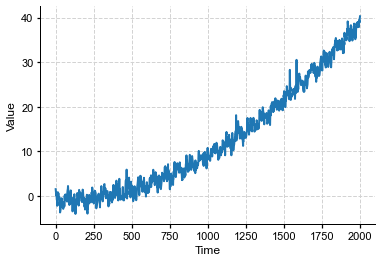

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add outliers

outliers_start = np.mean(signal)+5*np.std(signal)
outliers_end = np.mean(signal)+7*np.std(signal)
outlier_values = np.arange(outliers_start,outliers_end,0.1)
index = np.random.randint(0,len(signal),6)
signal_out = signal
for i,ind in enumerate(index):
    signal_out[ind] = outlier_values[i]

# Add a non-linear trend
slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept
signal_trend = signal + nonlinear_trend
#signal_trend = signal_out + nonlinear_trend

#Add white noise
sig_var = np.var(signal)
noise_var = sig_var / 2 #signal is twice the size of noise
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal_trend + white_noise

#Remove data points
del_percent = 0.4
n_del = int(del_percent*np.size(time))
deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
time_unevenly =  np.delete(time, deleted_idx)
signal_unevenly =  np.delete(signal_noise, deleted_idx)


#Plot
plt.plot(time_unevenly,signal_unevenly)
plt.xlabel('Time')
plt.ylabel('Value')

### Step 2: Create a series object for Pyleoclim

Create the time series object and write it as an intermediate output in JSON. 

In [4]:
import json

ts = pyleo.Series(time=time_unevenly,value=signal_unevenly)
PyleoObj_to_json(ts,'ts')

fig,ax = ts.plot(savefig_settings={'path':'./IntermediateOutputs/series_plot.png','format':'png'})

Figure saved at: "IntermediateOutputs/series_plot.png"


## Preprocessing

### Standarize

In [5]:
ts = json_to_Series('ts') #load JSON
ts_std = ts.standardize()
PyleoObj_to_json(ts_std,'ts_std') #write to JSON
fig,ax = ts_std.plot(savefig_settings={'path':'./IntermediateOutputs/standardize_plot.png','format':'png'})

Figure saved at: "IntermediateOutputs/standardize_plot.png"


### Detrend

In [6]:
ts_std = json_to_Series('ts_std') #load JSON
ts_detrended = ts_std.detrend(method='emd')
PyleoObj_to_json(ts_detrended,'ts_detrended') #write to JSON
fig,ax = ts_detrended.plot(savefig_settings={'path':'./IntermediateOutputs/detrend_plot.png','format':'png'})

Figure saved at: "IntermediateOutputs/detrend_plot.png"


### Detect outliers and remove outliers

Based on the detected outliers, may need to remove them prior to analysis. 

In this case, the if/else could happen within the component: do nothing on else but return a similar object to be used by the next component.

In [7]:
ts_detrended = json_to_Series('ts_detrended') #load JSON
ts_outliers = ts_detrended.outliers(saveknee_settings={'path':'./IntermediateOutputs/knee_plot.png',
                                                   'format':'png'},
                                    saveoutliers_settings={'path':'./IntermediateOutputs/outliers_plot.png',
                                                   'format':'png'})
PyleoObj_to_json(ts_outliers,'ts_outliers') #write to JSON

/Users/deborahkhider/opt/anaconda3/envs/pyleoclim/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Figure saved at: "IntermediateOutputs/knee_plot.png"
Figure saved at: "IntermediateOutputs/outliers_plot.png"


### Interpolation

This example uses a linear interpolation, other methods to achieve an evenly-spaced time series are spline interpolation, binning, and singular spectrum analysis. All methods could be equally valid and should be explored.

**First need to sense that the series is unevenly-spaced**

**Rule**: if the method spectral analysis is 'Lomb-Scargle' or 'WWZ', this step should be skipped (or same timeseries returned); else, this step is necessary. 

In [8]:
ts_outliers = json_to_Series('ts_outliers') #load JSON
ts_time=np.array(ts_outliers.__dict__['time'])
metadata = pyleo.utils.is_evenly_spaced(ts_time)
metadata

False

In [9]:
if metadata == False:
    ts_outliers = json_to_Series('ts_outliers') #load JSON
    ts_interp = ts_outliers.interp(method='linear')
    PyleoObj_to_json(ts_interp,'ts_interp') #write to JSON
    fig,ax = ts_interp.plot(savefig_settings={'path':'./IntermediateOutputs/interpolation_plot.png','format':'png'})

Figure saved at: "IntermediateOutputs/interpolation_plot.png"


### Analysis

### Spectral Analysis
#### WWZ and Lomb-Scargle

These methods don't require require evenly-spaced data in time, and therefore  uses the detrended time series.

In [10]:
%%time
#WWZ
ts_detrended = json_to_Series('ts_detrended') #load JSON
#psd_wwz = ts_detrended.spectral(settings={'method': 'Kirchner_f2py'})
psd_wwz = ts_detrended.spectral()
PyleoObj_to_json(psd_wwz,'psd_wwz')

CPU times: user 14.4 s, sys: 106 ms, total: 14.5 s
Wall time: 5.7 s


In [11]:
#Lomb-Scargle
ts_detrended = json_to_Series('ts_detrended') #load JSON
psd_lomb = ts_detrended.spectral(method='lomb_scargle')
PyleoObj_to_json(psd_lomb,'psd_lomb')

Just for fun, let's compare the two

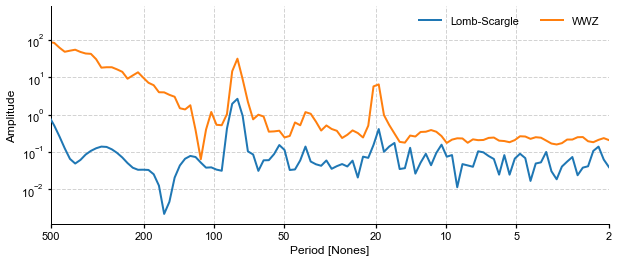

In [12]:
fig,ax = psd_lomb.plot(label='Lomb-Scargle', mute=True, zorder=99)
ax =  psd_wwz.plot(label='WWZ',ax=ax, lgd_kwargs={'ncol': 2})

#### MTM, Welch and Periodogram

This method requires evenly-spaced data in time, and therefore uses the interpreted time series.

In [13]:
#MTM
ts_interp = json_to_Series('ts_interp') #load JSON
psd_mtm = ts_interp.spectral(method='mtm')
PyleoObj_to_json(psd_mtm,'psd_mtm')

In [14]:
#Welch
ts_interp = json_to_Series('ts_interp') #load JSON
psd_welch = ts_interp.spectral(method='welch')
PyleoObj_to_json(psd_welch,'psd_welch')

In [15]:
# Periodogram
ts_interp = json_to_Series('ts_interp') #load JSON
psd_perio = ts_interp.spectral(method='periodogram')
PyleoObj_to_json(psd_perio,'psd_perio')

Let's compare all!!

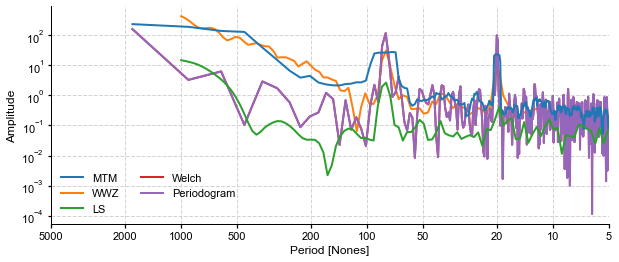

In [16]:
fig,ax = psd_mtm.plot(label='MTM', mute=True, zorder=99)
ax =  psd_wwz.plot(label='WWZ',ax=ax, lgd_kwargs={'ncol': 2})
ax =  psd_lomb.plot(label='LS',ax=ax, lgd_kwargs={'ncol': 2})
ax =  psd_welch.plot(label='Welch',ax=ax, lgd_kwargs={'ncol': 2})
ax =  psd_perio.plot(label='Periodogram',ax=ax, lgd_kwargs={'ncol': 2})

### Significance testing

The idea behind significance testing is to create surrogate timeseries that could mimic an expected process  in the system (eg. AR1) and test whether the observed peaks could be explained by chance. 

In [17]:
psd_mtm = json_to_PSD('psd_mtm')
psd_mtm_signif = psd_mtm.signif_test(qs=[0.95])
PyleoObj_to_json(psd_mtm_signif,filename='psd_mtm_signif')

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:10<00:00, 19.47it/s]


In [18]:
psd_wwz = json_to_PSD('psd_wwz')
psd_wwz_signif = psd_wwz.signif_test(qs=[0.95])
PyleoObj_to_json(psd_wwz_signif,'psd_wwz_signif')

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [19:19<00:00,  5.80s/it]


In [19]:
psd_welch = json_to_PSD('psd_welch')
psd_welch_signif = psd_welch.signif_test(qs=[0.95])
PyleoObj_to_json(psd_welch_signif,filename='psd_welch_signif')

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:00<00:00, 1099.38it/s]


In [20]:
psd_perio = json_to_PSD('psd_perio')
psd_perio_signif = psd_perio.signif_test(qs=[0.95])
PyleoObj_to_json(psd_perio_signif,filename='psd_perio_signif')

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:00<00:00, 1111.87it/s]


In [21]:
psd_lomb = json_to_PSD('psd_lomb')
psd_lomb_signif = psd_lomb.signif_test(qs=[0.95])
PyleoObj_to_json(psd_lomb_signif,filename='psd_lomb_signif')

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:00<00:00, 203.67it/s]


## Visualization

TypeError: expected str, bytes or os.PathLike object, not dict

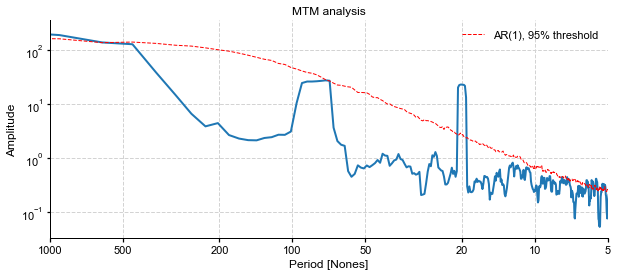

In [22]:
psd_mtm_signif = json_to_PSD('psd_mtm_signif')
fig, ax = psd_mtm_signif.plot(title='MTM analysis',savefig_settings={'path':'./IntermediateOutputs/mtm_plot.png','format':'png'})

In [34]:
psd_wwz_signif = json_to_PSD('psd_wwz_signif')
fig, ax = psd_wwz_signif.plot(title='WWZ Analysis',savefig_settings={'path':'./IntermediateOutputs/wwz_plot.png','format':'png'})

Figure saved at: "IntermediateOutputs/wwz_plot.png"


In [35]:
psd_lomb_signif = json_to_PSD('psd_lomb_signif')
fig, ax = psd_lomb_signif.plot(title='Lomb-Scargle Analysis',savefig_settings={'path':'./IntermediateOutputs/ls_plot.png','format':'png'})

Figure saved at: "IntermediateOutputs/ls_plot.png"


In [36]:
psd_welch_signif = json_to_PSD('psd_welch_signif')
fig, ax = psd_welch_signif.plot(title='Welch Analysis',savefig_settings={'path':'./IntermediateOutputs/welch_plot.png','format':'png'})

Figure saved at: "IntermediateOutputs/welch_plot.png"


In [10]:
psd_perio_signif = json_to_PSD('psd_perio_signif')
fig, ax = psd_perio_signif.plot(title='Periodogram Analysis',savefig_settings={'path':'./IntermediateOutputs/perio_plot.png','format':'png'})

Figure saved at: "IntermediateOutputs/perio_plot.png"


MTM, WWZ, and Lomb-Scargle Comparison

In [5]:
psd_mtm_signif = json_to_PSD('psd_mtm_signif')
psd_wwz = json_to_PSD('psd_wwz')
psd_lomb = json_to_PSD('psd_lomb')
fig,ax = psd_mtm_signif.plot(label='MTM', mute=True, zorder=99)
ax =  psd_wwz.plot(label='WWZ',ax=ax, lgd_kwargs={'ncol': 2})
ax =  psd_lomb.plot(label='Lomb-Scargle',ax=ax, lgd_kwargs={'ncol': 2})
pyleo.savefig(fig,settings={'path':'./IntermediateOutputs/comp_plot2.png','format':'png'})

Figure saved at: "IntermediateOutputs/comp_plot2.png"
